# Application 1: Showcase

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from jax import config

import pickle

config.update("jax_enable_x64", True)
from ssm4epi.models.hospitalization import (
    hospitalization_model,
    dates,
    unique_a,
    h_by_age,
    I_by_age,
)
from ssm4epi.models.util import from_consecutive_logits
from isssm.importance_sampling import mc_integration
from isssm.kalman import state_mode
from jax import vmap
from ssm4epi.patch import full_deps
import jax.numpy as jnp
from pyprojroot import here
import matplotlib.pyplot as plt
from isssm.estimation import initial_theta, mle_pgssm
from isssm.laplace_approximation import laplace_approximation as LA
from isssm.modified_efficient_importance_sampling import (
    modified_efficient_importance_sampling as MEIS,
)
from isssm.importance_sampling import pgssm_importance_sampling, ess_pct
import jax.random as jrn

Run hospitalization model on all data until final NCH evaluation date.

In [ ]:
from typing import NamedTuple
from jaxtyping import Float, Array, PRNGKeyArray
from scipy.optimize import OptimizeResult
from isssm.typing import GLSSMProposal


class HospitalizationResult(NamedTuple):
    a_index: int
    h: Float[Array, "..."]
    I: Float[Array, "..."]
    y: Float[Array, "np1 p"]
    theta0: Float[Array, "5"]
    theta0_result: OptimizeResult
    theta_hat: Float[Array, "5"]
    theta_hat_result: OptimizeResult
    proposal: GLSSMProposal
    key: PRNGKeyArray
    ess_pct: Float

In [ ]:
start_date = "2021-11-22"
end_date = "2022-04-29"

n_iter = 100
N_mle = 1000
N_meis = 1000
N_ess = 10000
N_fit = 10000
N_predict = 10000

In [ ]:
def showcase_result(a_index: int, n_delay: int) -> HospitalizationResult:
    i_start = int(jnp.where(dates == start_date)[0][0])
    np1 = int(jnp.where(dates == end_date)[0][0]) - i_start
    h = h_by_age[a_index][:, :n_delay]
    I = I_by_age[a_index][i_start : i_start + np1]
    unique_a[a_index]
    key = jrn.PRNGKey(4234809124)

    y = h[i_start : i_start + np1]
    aux = (np1, n_delay, 2, I)

    p0_hat = y[:7].sum() / I[:7].sum()
    theta_manual = jnp.log(jnp.array([1**2, 0.1**2, 0.1**2, 0.1**2, p0_hat]))

    theta0_result = initial_theta(y, hospitalization_model, theta_manual, aux, n_iter)
    theta0 = theta0_result.x
    key, subkey = jrn.split(key)
    mle_result = None
    theta_hat = None
    # mle_result = mle_pgssm(y, hospitalization_model, theta0, aux, n_iter, N_mle, subkey)
    # theta_hat = mle_result.x
    fitted_model = hospitalization_model(theta0, aux)

    proposal_la, _ = LA(y, fitted_model, n_iter)
    key, subkey = jrn.split(key)
    proposal_meis, _ = MEIS(
        y, fitted_model, proposal_la.z, proposal_la.Omega, n_iter, N_meis, subkey
    )
    key, subkey = jrn.split(key)
    proposal = proposal_meis
    _, log_weights = pgssm_importance_sampling(
        y, fitted_model, proposal.z, proposal.Omega, N_ess, subkey
    )

    result = HospitalizationResult(
        a_index,
        h,
        I,
        y,
        theta0,
        theta0_result,
        theta_hat,
        mle_result,
        proposal,
        key,
        ess_pct(log_weights),
    )

    with open(
        here()
        / "data"
        / "results"
        / "4_hospitalizations"
        / "showcase"
        / f"result_A{a_index}_D{n_delay}.pkl",
        "wb",
    ) as f:
        pickle.dump(result, f)

    print(f"Finished results for a_index {a_index} and n_delay {n_delay}")

    return result

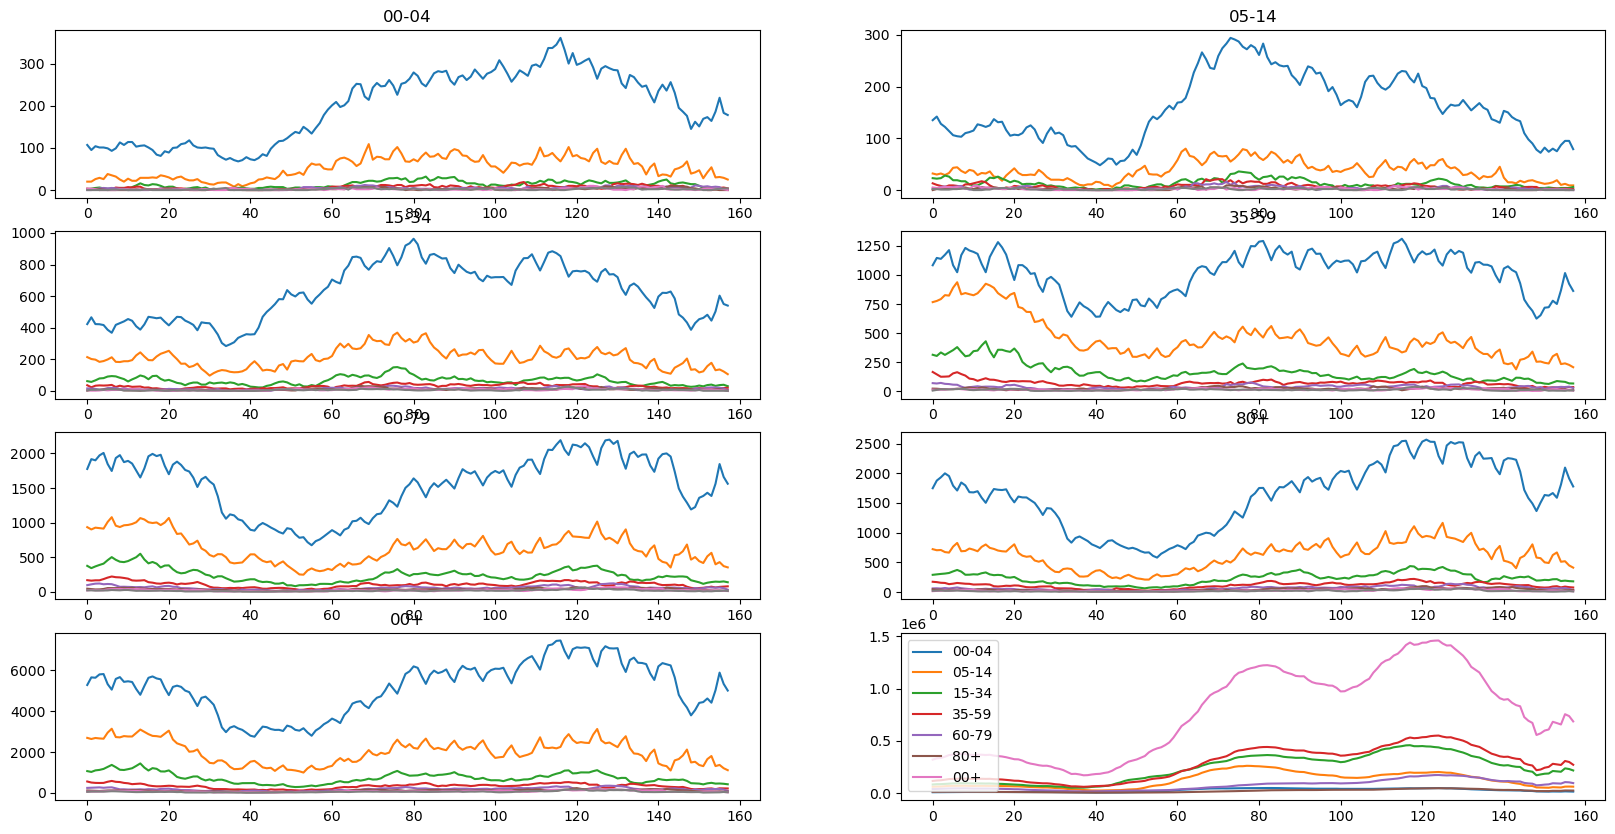

In [ ]:
fig, axs = plt.subplots(4, 2, figsize=(20, 10))
axs = axs.flatten()
for a_index in range(len(unique_a)):
    h = h_by_age[a_index]
    I = I_by_age[a_index]
    unique_a[a_index]
    i_start = int(jnp.where(dates == start_date)[0][0])
    np1 = int(jnp.where(dates == end_date)[0][0]) - i_start

    y = h[i_start : i_start + np1]
    axs[a_index].plot(y)
    axs[a_index].set_title(f"{unique_a[a_index]}")

axs[-1].plot(jnp.array(I_by_age).T[i_start : i_start + np1], label=unique_a)
axs[-1].legend()
plt.show()

In [ ]:
from ssm4epi.models.hospitalization import delays_per_age

results = [
    showcase_result(a_index, n_delay) for _, (a_index, n_delay) in delays_per_age.iterrows()
]

Finished results for a_index 0 and n_delay 5
Finished results for a_index 1 and n_delay 5
Finished results for a_index 2 and n_delay 7
Finished results for a_index 3 and n_delay 7
Finished results for a_index 4 and n_delay 8
Finished results for a_index 5 and n_delay 8
Finished results for a_index 6 and n_delay 8


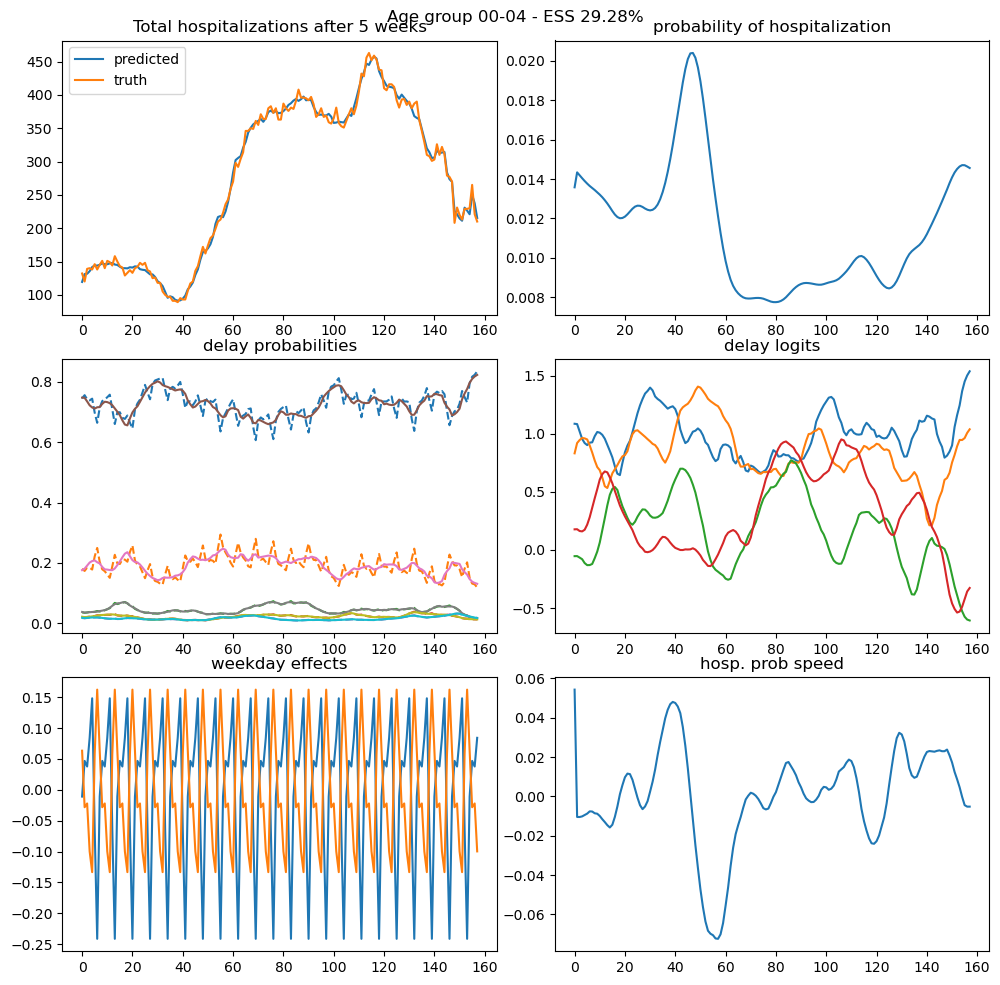

In [ ]:
from ssm4epi.models.hospitalization import visualize_model_fit


def visualize_result(result: HospitalizationResult):
    i_start = int(jnp.where(dates == start_date)[0][0])
    # I = result.I[i_start : i_start + np1]
    key, subkey = jrn.split(result.key)
    np1, n_delay = result.y.shape
    aux = (result.y.shape[0], n_delay, 2, result.I)
    model = hospitalization_model(result.theta0, aux)
    samples, log_weights = pgssm_importance_sampling(
        result.y,
        model,
        result.proposal.z,
        result.proposal.Omega,
        N_fit,
        subkey,
    )

    visualize_model_fit(
        samples, log_weights, model, i_start, np1, result.y, result.a_index
    )


visualize_result(results[0])

In [ ]:
from isssm.importance_sampling import prediction

key = jrn.PRNGKey(2342312412)
key, subkey_prediction = jrn.split(key)


def f_pred(x, s, y):
    np1, n_delay = y.shape
    p = jnp.exp(s[:, :1])
    delay_dist_smooth = from_consecutive_logits(x[:, 2 : (2 + n_delay - 1)])
    delay_dist_observed = from_consecutive_logits(s[:, 1:])
    weekday_1 = jnp.exp(x[:, (2 + n_delay - 1)][:, None])
    weekday_2 = jnp.exp(x[:, (2 + n_delay - 1 + 6)][:, None])
    average_delay = jnp.sum(
        delay_dist_smooth * jnp.arange(n_delay), axis=-1, keepdims=True
    )
    return jnp.concatenate(
        (
            p,
            delay_dist_smooth,
            delay_dist_observed,
            weekday_1,
            weekday_2,
            average_delay,
        ),
        axis=-1,
    )


percentiles_of_interest = jnp.array(
    [0.01, 0.025, *(0.05 * jnp.arange(1, 20)), 0.975, 0.99]
)


def stacked_prediction(f, result: HospitalizationResult):
    proposal = result.proposal
    result.theta0
    fitted_model = hospitalization_model(
        result.theta0, (result.y.shape[0], result.y.shape[1], 2, result.I)
    )
    mean, sd, quantiles = prediction(
        f,
        result.y,
        proposal,
        fitted_model,
        N_predict,
        subkey_prediction,
        percentiles_of_interest,
    )
    return jnp.vstack((mean[None], sd[None], quantiles))


for i, result in enumerate(results):
    jnp.save(
        here()
        / f"data/results/4_hospitalizations/showcase/predictions_age_{unique_a[i]}.npy",
        stacked_prediction(f_pred, result),
    )

## `data/results/4_hospitalizations/showcase/hyperparams.tex`

In [ ]:
hyperparams_statement = f"""
To fit the model for all age groups, we use at most {n_iter} iterations for all occurences of the \\acrshort{{la}}, with a convergence threshold set to $10^{{-5}}$ relative difference in $z$ and $\\Omega$. We use the same method for \\acrshort{{eis}}, where we additionally use ${N_meis:,}$ samples to determine the optimal proposal, starting with the proposal given by th \\acrshort{{la}}.

For \\acrshort{{mle}}, we use ${N_mle:,}$ samples to determine the maximum likelihood estimate of the parameters, initializing at the initial guess given by \\Cref{{alg:mle}}.
To obtain prediction intervals of the states, signals and missing observations we use ${N_predict:,}$ samples. To estimate the \\acrshort{{ess}} we use ${N_ess:,}$ samples. Note that all sample sizes are given before constructing the three antithetic variables.
"""

# write to tex file
with open(
    here() / "data/results/4_hospitalizations/showcase/hyperparams.tex", "w"
) as f:
    f.write(hyperparams_statement)

In [ ]:
import pandas as pd

with open(here() / "tables" / "hospitalization_showcase_ess.tex", "w") as f:
    table = pd.DataFrame(
        {
            "Age group": [f"A{a}" for a in unique_a],
            "EF [%]": [f"{result.ess_pct:.0f}" for result in results],
            "weeks of delay": n_delays,
        }
    ).to_latex(index=False)
    f.write(table)

/var/folders/9y/xdxkkt710kx5tf1j0p68y46r0000gn/T/ipykernel_19755/377309747.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table = pd.DataFrame(
